In [2]:
import scanpy as sc

from scprint2 import scPRINT2

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd
from anndata import AnnData
import matplotlib.pyplot as plt
import scipy.sparse
from collections import Counter

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


→ connected lamindb: jkobject/scprint2


## Loading the data

## https://www.nature.com/articles/s41592-020-0935-4#data-availability

In [1]:
! mkdir -p /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp
! wget  https://www.ncbi.nlm.nih.gov/geo/download/\?acc=GSE141851\&format=file
! mv index.html\?acc=GSE141851\&format=file /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSE141851.tar
! cd /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/ && tar xf GSE141851.tar

--2025-01-21 17:31:40--  https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE141851&format=file
Resolving maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)... 192.168.148.66
Connecting to maestro-squid.maestro.pasteur.fr (maestro-squid.maestro.pasteur.fr)|192.168.148.66|:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 172615680 (165M) [application/x-tar]
Saving to: ‘index.html?acc=GSE141851&format=file’

index.html?acc=GSE1 100%[===================>] 164.62M  15.4MB/s    in 11s     

2025-01-21 17:31:52 (14.4 MB/s) - ‘index.html?acc=GSE141851&format=file’ saved [172615680/172615680]



In [4]:
# Create list of all files
files = ! ls /pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM451*
files[:]

['/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512669_Neu-Kcl-0min_C.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512669_Neu-Kcl-0min_T.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512670_Neu-Kcl-15min_C.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512670_Neu-Kcl-15min_T.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512671_Neu-Kcl-30min_C.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512671_Neu-Kcl-30min_T.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512672_Neu-Kcl-60min_C.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512672_Neu-Kcl-60min_T.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512673_Neu-Kcl-120min_C.txt.gz',
 '/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/GSM4512673_Neu-Kcl-120min_T.txt.gz',
 '/pasteur/zeus/proj

In [5]:

# Read and concatenate all files into one AnnData object
adatas_T = []
adatas_C = []
for i, file in enumerate(files[:]):
    # Extract metadata from filename
    basename = file.split('/')[-1].replace('.txt.gz','')
    gsm = basename.split('_')[0]
    condition = '_'.join(basename.split('_')[1:-1])
    if "Neu-Kcl" in condition:
        time = int(condition.split('-')[-1][:-3])
        condition = "neuron"
    elif "mESC" in condition:
        if "WT" in condition:
            time = 0
            condition = "WT"
        elif "Chase" in condition:
            time = condition.split('-')[-1]
            condition = "mESC"
            if "hr" in time:
                time = 60*int(time[:-2])
            else:
                time = int(time[:-3])
        else:
            continue
    else:
        continue
        
    data_type = basename.split('_')[-1]  # C or T
    
    # Read data
    df = pd.read_csv(file, sep='\t', compression='gzip')
    if data_type == 'T':
        adata_T = AnnData(df.T)
        # Add metadata
        adata_T.obs['gsm'] = gsm
        adata_T.obs['condition'] = condition
        adata_T.obs['time'] = time
        adata_T.obs['data_type'] = data_type
        # Convert to sparse format
        adata_T.X = scipy.sparse.csr_matrix(adata_T.X)
        adatas_T.append(adata_T)
    else:
        adata_C = AnnData(df.T)
        adata_C.obs['gsm'] = gsm
        adata_C.obs['condition'] = condition
        adata_C.obs['data_type'] = data_type
        adata_C.obs['time'] = time
        adata_C.X = scipy.sparse.csr_matrix(adata_C.X)
        adatas_C.append(adata_C)

adata_T = sc.concat(adatas_T)
adata_C = sc.concat(adatas_C)

In [ ]:
set([i.split('_')[-2] for i in files])

{'K562-4SU',
 'K562-4SU-N9',
 'K562-4SU-TFEA',
 'K562-4SU-TFEA-N9',
 'K562-NTC-TFEA',
 'K562-NTC-TFEA-N9',
 'Neu-Kcl-0min',
 'Neu-Kcl-120min',
 'Neu-Kcl-15min',
 'Neu-Kcl-30min',
 'Neu-Kcl-60min',
 'mESC-TetTKO-rep1',
 'mESC-TetTKO-rep2',
 'mESC-WT-rep1',
 'mESC-WT-rep2',
 'mESC-b1-Chase-0min',
 'mESC-b1-Chase-12hr',
 'mESC-b1-Chase-24hr',
 'mESC-b1-Chase-30min',
 'mESC-b1-Chase-3hr',
 'mESC-b1-Chase-60min',
 'mESC-b1-Chase-6hr',
 'mESC-b2-Chase-0min',
 'mESC-b2-Chase-12hr',
 'mESC-b2-Chase-24hr',
 'mESC-b2-Chase-30min',
 'mESC-b2-Chase-3hr',
 'mESC-b2-Chase-60min',
 'mESC-b2-Chase-6hr'}

In [6]:
adatas_C[0].X.sum(1)

matrix([[1707],
        [3315],
        [2475],
        ...,
        [  39],
        [  47],
        [  43]])

In [9]:
adatas_T[0].X.sum(1)


NameError: name 'adatas_T' is not defined

In [8]:
adata = sc.concat(adatas_T)
adata.layers['new'] = sc.concat(adatas_C).X
del adatas_C, adatas_T

adata.obs['organism_ontology_term_id'] = 'NCBITaxon:10090'

preprocessor = Preprocessor(keepdata=True,is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())

adata.write_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/scntseq.h5ad')


... storing 'gsm' as categorical
... storing 'condition' as categorical
... storing 'data_type' as categorical
... storing 'condition' as categorical
... storing 'data_type' as categorical


In [10]:
adata = sc.read_h5ad('/pasteur/zeus/projets/p02/ml4ig_hot/Users/jkalfon/data/temp/scntseq.h5ad')

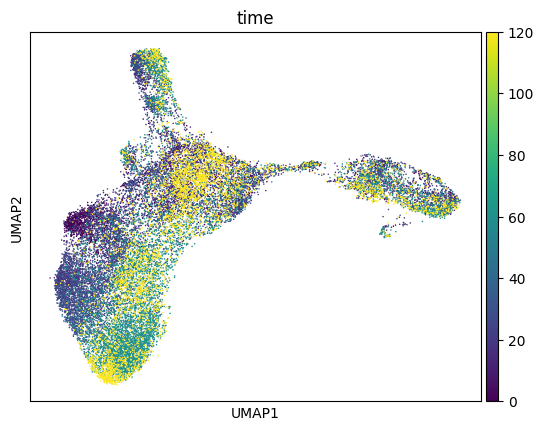

In [24]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
subadata = adata[adata.obs['condition'] == 'neuron']
sc.pp.highly_variable_genes(subadata, flavor='seurat_v3', n_top_genes=3000)
subadata = subadata[:, subadata.var.highly_variable]

# Run UMAP
sc.pp.pca(subadata, n_comps=30)
sc.pp.neighbors(subadata, n_neighbors=8, use_rep='X_pca')
sc.tl.umap(subadata, min_dist=0.1, spread=1)
sc.pl.umap(subadata, color='time')

/pasteur/appa/homes/jkalfon/miniconda3/envs/scprint2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


KeyError: 'Could not find key treatment_time in .var_names or .obs.columns.'

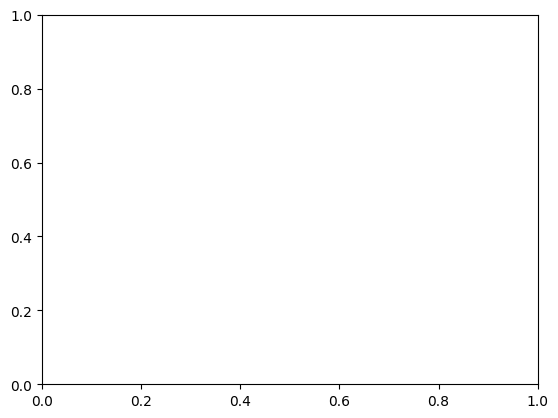

In [25]:
sc.pp.normalize_total(adata, target_sum=1e4, layer='new')
sc.pp.log1p(adata, layer='new')
subadata = adata[adata.obs['condition'] == 'neuron']
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=3000, layer='new')
subadata = adata[:, adata.var.highly_variable]

# Run UMAP
sc.pp.pca(subadata, n_comps=30, layer='new')
sc.pp.neighbors(subadata, n_neighbors=8, use_rep='X_pca')
sc.tl.umap(subadata, min_dist=0.1, spread=1)
sc.pl.umap(subadata, color='time')


In [27]:
subadata

AnnData object with n_obs × n_vars = 53625 × 3000
    obs: 'gsm', 'condition', 'time', 'data_type', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'unseen_genes', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'new'
    obsp: 'distances', 'connectivities'

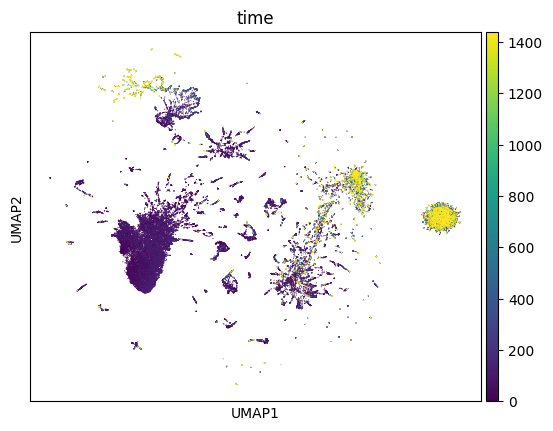

In [26]:
sc.pl.umap(subadata, color='time')


In [19]:
sc.pp.adata

AnnData object with n_obs × n_vars = 53625 × 57066
    obs: 'gsm', 'condition', 'time', 'data_type', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'
    layers: 'new'